In [1]:
#default_exp steam_data

In [1]:
#export 

import os
import re

import scipy
import pandas as pd
import tqdm

from sklearn import compose, feature_extraction, metrics, model_selection
from functools import reduce, partial
import numpy as np
import attr
import seaborn as sns
import pickle

In [3]:
#export

METACRITIC_GAME_METADATA_PATH = 'data/metacritic-video-game-comments/metacritic_game_info.csv'
STEAM_GAME_METADATA_PATH = 'data/steam_games_metadata/steam_games.csv'
STEAM_GAME_RATINGS_PATH = 'data/steam-video-games/steam-200k.csv'

# Steam data

In [4]:
%cd ..

/home/kuba/Projects/game_recommender


In [5]:
!ls data/steam_games_metadata/

steam_games.csv


In [6]:
!ls data/steam-video-games/

steam-200k.csv


In [7]:
raw_steam_df = pd.read_csv(STEAM_GAME_METADATA_PATH)

# Preprocessing

The two datasets we use:

- trolukovich/steam-games-complete-dataset
- tamber/steam-video-games

Have incompatible names, so we need to normalize them.

In [8]:
# export

characters_replaced_with_space_regex = re.compile('[\:,®-–"™]') 
dropped_patterns_regex = re.compile('beta|demo')


def normalize_numerals(name):
    normalized_name = name
    numeral_patterns = [
        ('ii', '2'),
        ('iii', '3'),
        ('iv', '4'),
        ('vi', '6'),
        ('v', '5')
   ]
    for (numeral, normalized_numeral) in numeral_patterns:
        numeral_pattern = ' ' + numeral + '($| )'
        normalized_numeral_pattern = ' ' + normalized_numeral + '\\1'
        normalized_name = re.sub(numeral_pattern, normalized_numeral_pattern, normalized_name) 
    return normalized_name


def normalize_name(name):
    
    name_without_illegal_characters = re.sub(characters_replaced_with_space_regex, ' ', name)
    name_without_illegal_characters = re.sub(dropped_patterns_regex, '', name_without_illegal_characters)
        
    name_without_illegal_characters = (
        name_without_illegal_characters
        .replace('!', ' ')
        .replace('(', ' ')
        .replace(')', ' ')
        .replace('+', ' ')
        .replace('-', ' ')
        .replace('&', 'and')
        .replace('’', "'")
        .replace('`', "'")
        .replace('’', "'")
        .replace("'s", "s")
        .replace("'t", 't')
        .replace('hd', '')
        .replace('gold edition', 'gold')
        .replace('gold pack', 'gold')
        .replace('osx', '')
        .lower()
    )
    name_without_multiple_whitespaces = re.sub('\s+', ' ', name_without_illegal_characters)
    name_with_normalized_numerals = normalize_numerals(name_without_multiple_whitespaces)
    return name_with_normalized_numerals.lower().strip()


def normalize_names(name_col):
    return name_col.apply(normalize_name)

In [9]:
assert normalize_name("Sid Meier's Civilization IV") == 'sid meiers civilization 4'
assert normalize_name("Sid Meier's Civilization IV Warlords") == 'sid meiers civilization 4 warlords'

# Basic information

In [10]:
raw_steam_df.head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","English,French,Italian,German,Spanish - Spain,...",NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","English,German,Russian,French",NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN


In [11]:
raw_steam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 20 columns):
url                         40833 non-null object
types                       40831 non-null object
name                        40817 non-null object
desc_snippet                27612 non-null object
recent_reviews              2706 non-null object
all_reviews                 28470 non-null object
release_date                37654 non-null object
developer                   40490 non-null object
publisher                   35733 non-null object
popular_tags                37888 non-null object
game_details                40313 non-null object
languages                   40797 non-null object
achievements                12194 non-null float64
genre                       40395 non-null object
game_description            37920 non-null object
mature_content              2897 non-null object
minimum_requirements        21069 non-null object
recommended_requirements    21075 non-null

# Content without names

These correspond to steam product bundles. These aren't really games so we drop them. 

In [12]:
raw_steam_df[raw_steam_df['name'].isna()].head()

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
704,https://store.steampowered.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$29.99,$23.99
4847,https://store.steampowered.com/bundle/6191/The...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,About this bundle Get all extra characters i...,NaN,NaN,NaN,NaN,$18.84
6381,https://store.steampowered.com/bundle/7125/Fac...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,About this bundle This bundle contains thre...,NaN,NaN,NaN,NaN,$2.67
7869,https://store.steampowered.com/bundle/10241/Da...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$53.96
9615,https://store.steampowered.com/bundle/8069/Hap...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,About this bundle Happy Bat VR Bundle contai...,NaN,NaN,NaN,NaN,$11.03


# Data cleaning

We remove entries that have a null in any of interesting fields

In [13]:
#export

def clean_steam_df(raw_steam_df):
    text_columns = [
        'name',
        'game_description',
        'game_details',
        'popular_tags',
        'desc_snippet',
        'genre'
    ]
    invalid_indices = reduce(
        lambda s1, s2: s1 | s2,
        [raw_steam_df[c].isna() for c in text_columns])


    tag_cols = ['popular_tags', 'game_details', 'genre']

    steam_df = raw_steam_df.copy()[~invalid_indices]
    steam_df.index = pd.RangeIndex(0, len(steam_df))
    for c in tag_cols:
        steam_df[c] = steam_df[c].str.lower()
        
    steam_df['name_unnormalized'] = steam_df['name']
    steam_df['name'] = normalize_names(steam_df['name'])
    return steam_df


def load_steam_df(steam_games_metadata_path=STEAM_GAME_METADATA_PATH):
    return clean_steam_df(pd.read_csv(steam_games_metadata_path))


def get_games_by_name(steam_df, substr):
    game_names = steam_df['name'][steam_df['name'].str.contains(substr)]
    return steam_df[steam_df['name'].isin(game_names)]


In [14]:
steam_df = load_steam_df() 

In [15]:
steam_df['name']

0                                 doom
1        playerunknown's battlegrounds
2                           battletech
3                                 dayz
4                           eve online
                     ...              
24205                      gamers club
24206                           gravia
24207                         galactis
24208                            alive
24209                 stories in stone
Name: name, Length: 24210, dtype: object

In [16]:
chosen_games_substring = 's.t.a.l.k'

In [17]:
chosen_games_df = get_games_by_name(steam_df, chosen_games_substring) 

In [18]:
chosen_games_df['name']

376     s.t.a.l.k.e.r. shadow of chernobyl
1276        s.t.a.l.k.e.r. call of pripyat
7253              s.t.a.l.k.e.r. clear sky
Name: name, dtype: object

In [19]:
chosen_games_df.iloc[0]['popular_tags']

'atmospheric,post-apocalyptic,open world,fps,survival,masterpiece,action,rpg,survival horror,shooter,horror,first-person,singleplayer,classic,based on a novel,moddable,adventure,sci-fi,inventory management,difficult'

In [20]:
chosen_games_df.iloc[0]['game_details']

'single-player,multi-player'

In [21]:
chosen_games_df.iloc[0]['genre']

'action,rpg'

In [22]:
chosen_games_df['game_description'].iloc[0]

" About This Game In 1986, the world's worst nuclear disaster occurred at the Chernobyl Nuclear Power Plant. Soviet authorities established an 'Exclusion Zone' around, but a second explosion hit the reactor in 2006, creating The Zone as we know it – dangerous place, filled with mutated creatures, deadly radiation, and a strange, anomalous energy. The Zone was cordoned off by the military, who would shoot on sight anyone foolish enough to get inside.  Year 2012. The Zone is still a dangerous place and a threat to all mankind. Mercenaries, bounty hunters and explorers ventured further and further into the heart of the Zone driven by reports of strange 'artifacts' imbued with anomalous energy. To sell them on the black market or trying to find the 'truth' behind the Zone. Whatever their motivation, over time these individuals - Scavengers, Trespassers, Adventurers, Loners, Killers, Explorers and Robbers - have become known as S.T.A.L.K.E.R.s.  You will have to find your own way to survive

In [23]:
chosen_games_df['popular_tags'].iloc[0]

'atmospheric,post-apocalyptic,open world,fps,survival,masterpiece,action,rpg,survival horror,shooter,horror,first-person,singleplayer,classic,based on a novel,moddable,adventure,sci-fi,inventory management,difficult'

In [24]:
game_descriptions = steam_df['game_description']

# Steam200k

In [25]:
!head $STEAM_GAME_RATINGS_PATH

151603712,"The Elder Scrolls V Skyrim",purchase,1.0,0
151603712,"The Elder Scrolls V Skyrim",play,273.0,0
151603712,"Fallout 4",purchase,1.0,0
151603712,"Fallout 4",play,87.0,0
151603712,"Spore",purchase,1.0,0
151603712,"Spore",play,14.9,0
151603712,"Fallout New Vegas",purchase,1.0,0
151603712,"Fallout New Vegas",play,12.1,0
151603712,"Left 4 Dead 2",purchase,1.0,0
151603712,"Left 4 Dead 2",play,8.9,0


In [26]:
# export


def load_steam_ratings_df(steam_ratings_path=STEAM_GAME_RATINGS_PATH):
    steam_ratings_df = pd.read_csv(STEAM_GAME_RATINGS_PATH)
    steam_ratings_df.columns = ['user_id', 'name', 'ownership', 'hours', 'useless']
    steam_ratings_df['log_hours'] = np.log1p(steam_ratings_df['hours'])
    steam_ratings_df['played'] = 1 * (steam_ratings_df['ownership'] == 'play')
    steam_ratings_df['interacted'] = 1
    steam_ratings_df['name_unnormalized'] = steam_ratings_df['name']
    steam_ratings_df['name'] = normalize_names(steam_ratings_df['name'])
    return steam_ratings_df.drop(axis='columns', columns=['useless'])


In [27]:
#export


@attr.s
class RecommenderDataset:
    
    data = attr.ib()
    target = attr.ib()
    target_col = attr.ib(default='log_hours')
    
    def filter_out_insufficient_reviews(self, col, threshold):
        is_number_of_reviews_sufficient = self._get_column_with_sufficient_reviews(self.data, col, threshold)
        new_data = self.data[is_number_of_reviews_sufficient]
        new_target = self.target[is_number_of_reviews_sufficient]
        return RecommenderDataset(new_data, new_target, self.target_col)
    
    @classmethod
    def _get_column_with_sufficient_reviews(cls, ratings_df, col, threshold):
        game_review_counts = ratings_df.groupby(col).agg('count').iloc[:,0]
        return ratings_df[col].isin(
            game_review_counts.index[game_review_counts >= threshold]
        )
    
    @staticmethod
    def make_collaborative_filtering_dataset(steam_ratings_df, target_col='log_hours'):
        """
        Clean data so that and 'hours' makes sense as target:
        for players who played a game delete record of buying
        """
        steam_ratings_df = steam_ratings_df[steam_ratings_df['played'] == 1]
        target = steam_ratings_df[target_col]
        data = steam_ratings_df.drop(columns=[target_col])
        return RecommenderDataset(data, target, target_col)
    
    @staticmethod
    def make_implicit_feedback_dataset(steam_ratings_df, target_col='log_hours'):
        """
        Clean data so that and 'hours' is an implicit feedback target:
        players that bought a game and didn't play it are treated as negative example
        """
        filtered_steam_ratings_df = steam_ratings_df.groupby(['name', 'user_id']).apply(
            lambda df: df if len(df) == 1 else df[df['ownership'] == 'play']
        )
        filtered_steam_ratings_df.index = pd.RangeIndex(len(filtered_steam_ratings_df))
        not_played = steam_ratings_df['played'] == 0
        target = filtered_steam_ratings_df[target_col]
        data = filtered_steam_ratings_df.drop(columns=[target_col])
        return RecommenderDataset(data, target, target_col)
    
    def get_user_item_df(self):
        ratings_df = pd.concat([self.data, self.target], axis=1)
        return ratings_df.pivot_table(index='user_id', columns='name', values='log_hours')
    
    @staticmethod
    def make_user_item_train_val_split(user_item_df, test_size=0.2):
        """
        Make train-test split stratified by number of played games
        """
        user_played_game_counts = (user_item_df > 0).sum(axis=1)
        return model_selection.train_test_split(user_item_df, test_size=test_size, stratify=user_played_game_counts)

In [28]:
#export


def get_item_user_matrix_train_val_split(dataset,  train_labels, labels_val):
    steam_df, target = dataset.data, dataset.target
    ratings_df = pd.concat([steam_df, target], axis=1)
    item_user_pivoted_df = ratings_df.pivot_table(index='name', columns='user_id', values='log_hours')
    user_game_matrix_train = scipy.sparse.csr_matrix(item_user_pivoted_df.loc[:, steam_df.iloc[train_labels].index].fillna(0))
    for __, row in tqdm.tqdm(ratings_df.iloc[labels_val].iterrows()):
        item_user_pivoted_df.loc[row['name'], row['user_id']] = 0
    
    user_game_matrix_train = scipy.sparse.csr_matrix(item_user_pivoted_df.loc[:, steam_df.iloc[train_labels]['user_id'].unique()].fillna(0))
    item_user_pivoted_df.iloc[:,:] = 0
    for i, row in tqdm.tqdm(ratings_df.iloc[labels_val].iterrows()):
        value = ratings_df[(ratings_df['user_id'] == row['user_id']) & (ratings_df['name'] == row['name'])]['log_hours'].iloc[0]
        if i == 0:
            print(value)
            print(value.shape)
        item_user_pivoted_df.loc[row['name'], row['user_id']] = value
    
    user_game_matrix_val = scipy.sparse.csr_matrix(item_user_pivoted_df.loc[:, steam_df.iloc[labels_val]['user_id'].unique()].fillna(0))
    return user_game_matrix_train.T, user_game_matrix_val.T

In [29]:
steam_df.describe()

,achievements
count,12168.000000
mean,77.362179
std,448.971950
min,1.000000
25%,12.000000
50%,21.000000
75%,38.000000
max,9821.000000


In [30]:
steam_ratings_df = load_steam_ratings_df()
steam_ratings_df.groupby('user_id').agg('count')['name'].describe()

count    12393.000000
mean        16.138062
std         51.878442
min          1.000000
25%          2.000000
50%          3.000000
75%          9.000000
max       1573.000000
Name: name, dtype: float64

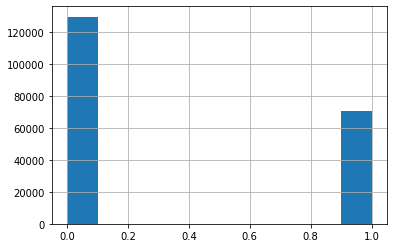

In [31]:
steam_ratings_df['played'].hist()

In [32]:
steam_ratings_df['hours'].min()

0.1

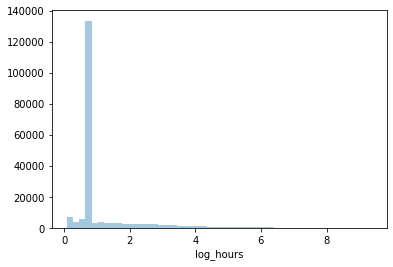

In [33]:
sns.distplot(steam_ratings_df['log_hours'], kde=False)

In [34]:
#ds = RecommenderDataset.make_implicit_feedback_dataset(steam_ratings_df)

In [35]:
#ds.data.index = pd.RangeIndex(len(ds.data))

In [36]:
steam_ratings_df.head()

,user_id,name,ownership,hours,log_hours,played,interacted,name_unnormalized
0,151603712,the elder scrolls 5 skyrim,play,273.0,5.613128,1,1,The Elder Scrolls V Skyrim
1,151603712,fallout 4,purchase,1.0,0.693147,0,1,Fallout 4
2,151603712,fallout 4,play,87.0,4.477337,1,1,Fallout 4
3,151603712,spore,purchase,1.0,0.693147,0,1,Spore
4,151603712,spore,play,14.9,2.766319,1,1,Spore


In [37]:
len(set(steam_ratings_df.name))

5152

In [38]:
len(set(steam_df.name))

24139

In [39]:
games_with_metadata = set(normalize_names(steam_df['name']))
games_with_reviews = set(normalize_names(steam_ratings_df['name']))
games_without_metadata = games_with_reviews - games_with_metadata

print(len(games_without_metadata))

2323


In [40]:
steam_ratings_df.shape

(199999, 8)

Ratings with games with metadata

In [57]:
#export


def filter_ratings_with_metadata(steam_ratings_df, steam_df=None):
    if steam_df is None:
        steam_df = load_steam_df()
    games_with_metadata = set(steam_df['name'])
    return steam_ratings_df[steam_ratings_df['name'].isin(games_with_metadata)]


In [42]:
steam_ratings_with_metadata_df = filter_ratings_with_metadata(steam_ratings_df)
steam_ratings_with_metadata_df.shape

(140818, 8)

In [ ]:
from fuzzywuzzy import fuzz
from operator import itemgetter
import tqdm

for game_name in games_without_metadata:
    similarities = [(name, fuzz.ratio(game_name, name) / 100) for name in set(steam_df.name)] 
    similarities = sorted(similarities, key=itemgetter(1), reverse=True)
    if similarities[0][1] > 0.85:
        print(game_name, similarities[0])

In [43]:
steam_ratings_df[steam_ratings_df.name.isin(games_without_metadata)].groupby('name').agg('count')

,user_id,ownership,hours,log_hours,played,interacted,name_unnormalized
name,,,,,,,
007 legends,2,2,2,2,2,2,2
0rbitalis,6,6,6,6,6,6,6
1000 amps,3,3,3,3,3,3,3
12 labours of hercules,17,17,17,17,17,17,17
15 days,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
zombie tycoon 2 brainhovs revenge,2,2,2,2,2,2,2
zombies monsters robots,81,81,81,81,81,81,81
zooloretto,1,1,1,1,1,1,1


In [44]:
games_without_metadata

{'over the dream',
 'csgo player profiles',
 'frontline tactics close quater combat soldier',
 'lumber island that special place',
 'tom clancys ghost recon phantoms na looks and power recon',
 'curse of the assassin',
 'this war of mine war child charity dlc',
 'running shadow',
 'sword of the stars the pit juggernaut',
 'draw a stickman epic',
 'age of wonders trilogy soundtrack',
 'dragon quest heroes',
 'balls of steel',
 'jazzpunk',
 'clickr',
 'warhammer quest base pack items',
 'wizardry online',
 'the static speaks my name',
 'project aura',
 'hero siege the karp of doom',
 'nandeyanen ? the 1st stra',
 'alan wakes american nightmare',
 'silent storm sentinels',
 'war of the vikings',
 'elements soul of fire',
 'nightbanes',
 'vanguard princess kurumi',
 'the ultimate doom',
 'defense grid resurgence map pack 2',
 'karmaflow the rock opera videogame',
 'football manager 2016',
 'wallace and gromit ep 4 the bogey man',
 'tdp4team battle',
 'counter strike nexon zombies starter p

In [45]:
steam_ratings_df[steam_ratings_df.name.str.lower().str.replace(':','').isin(games_without_metadata)].groupby('name').agg('count')

,user_id,ownership,hours,log_hours,played,interacted,name_unnormalized
name,,,,,,,
007 legends,2,2,2,2,2,2,2
0rbitalis,6,6,6,6,6,6,6
1000 amps,3,3,3,3,3,3,3
12 labours of hercules,17,17,17,17,17,17,17
15 days,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
zombie tycoon 2 brainhovs revenge,2,2,2,2,2,2,2
zombies monsters robots,81,81,81,81,81,81,81
zooloretto,1,1,1,1,1,1,1


In [46]:
steam_ratings_df[steam_ratings_df.name.str.lower().str.replace(':','').isin(games_without_metadata)].groupby('name').agg('count')

,user_id,ownership,hours,log_hours,played,interacted,name_unnormalized
name,,,,,,,
007 legends,2,2,2,2,2,2,2
0rbitalis,6,6,6,6,6,6,6
1000 amps,3,3,3,3,3,3,3
12 labours of hercules,17,17,17,17,17,17,17
15 days,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
zombie tycoon 2 brainhovs revenge,2,2,2,2,2,2,2
zombies monsters robots,81,81,81,81,81,81,81
zooloretto,1,1,1,1,1,1,1


In [58]:
filtered_steam_ratings_df = filter_ratings_with_metadata(steam_ratings_df)

In [ ]:
!rm data/game

In [ ]:
#export


def get_steam_ratings_dataset(maybe_pickle_path='data/game_dataset.pkl', min_user_ratings=5, min_game_ratings=2):

    game_dataset_pickle_path = 'data/game_dataset.pkl'
    if os.path.exists(game_dataset_pickle_path):
        game_dataset_raw = pickle.load(open(game_dataset_pickle_path, 'rb'))
    else:
        raw_steam_ratings_df = load_steam_ratings_df()
        steam_ratings_df = filter_ratings_with_metadata(raw_steam_ratings_df)
        game_dataset_raw = RecommenderDataset.make_implicit_feedback_dataset(steam_ratings_df)
        pickle.dump(game_dataset_raw, open(game_dataset_pickle_path, 'wb'))

    game_dataset = (
        game_dataset_raw
        .filter_out_insufficient_reviews('user_id', min_user_ratings)
        .filter_out_insufficient_reviews('name', min_game_ratings)
    )
    return game_dataset